### Bias Field Correction

**Learning outcomes:**
- Learn how to apply Bias Field Correction to an image using SITK.
- Inspect Bias Field visually.

In [1]:
%matplotlib inline

import os
from helpers import *

import ants
# noinspection PyPep8Naming
import SimpleITK as sitk

print(f'AntsPy version = {ants.__version__}')
print(f'SimpleITK version = {sitk.__version__}')

AntsPy version = 0.5.4
SimpleITK version = 2.4.1


In [2]:
BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
print(f'project folder = {BASE_DIR}')

project folder = /home/younes/PycharmProjects/MRI-preprocessing-techniques


In [3]:
raw_examples = [
    'fsl-open-dev_sub-001_T1w.nii.gz',
    'wash-120_sub-001_T1w.nii.gz',
    'kf-panda_sub-01_ses-3T_T1w.nii.gz',
    'listen-task_sub-UTS01_ses-1_T1w.nii.gz',
]

#### Load image

shape = (192, 192, 160) -> (Z, X, Y)


interactive(children=(IntSlider(value=95, description='SLICE', max=191), Output()), _dom_classes=('widget-inte…

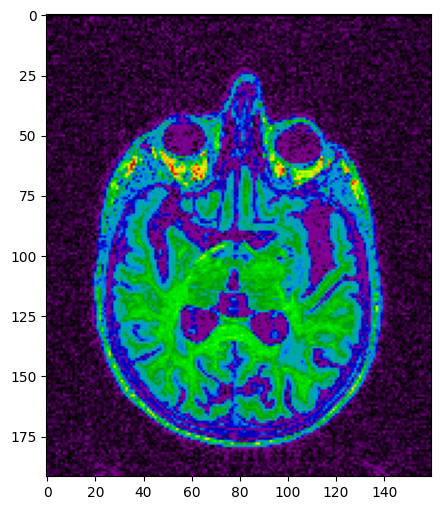

In [4]:
raw_example = raw_examples[0]
raw_img_path = os.path.join(BASE_DIR, 'assets', 'raw_examples', raw_example)
raw_img_sitk = sitk.ReadImage(raw_img_path, sitk.sitkFloat32)
raw_img_sitk = sitk.DICOMOrient(raw_img_sitk,'RPS')

raw_img_sitk_arr = sitk.GetArrayFromImage(raw_img_sitk)
print(f'shape = {raw_img_sitk_arr.shape} -> (Z, X, Y)')
explore_3D_array(raw_img_sitk_arr, cmap='nipy_spectral')

#### Create head mask

interactive(children=(IntSlider(value=95, description='SLICE', max=191), Output()), _dom_classes=('widget-inte…

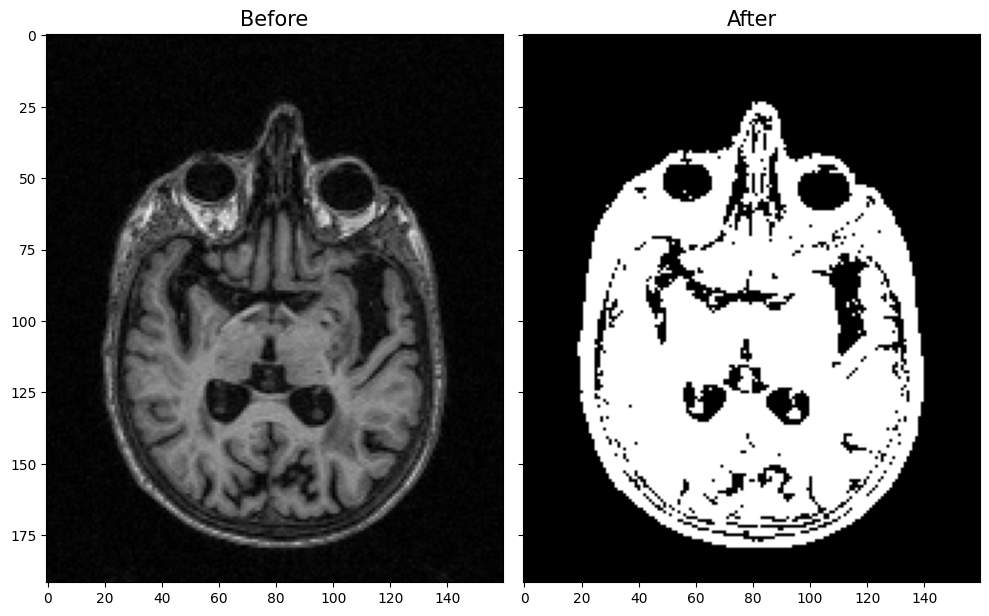

In [5]:
transformed = sitk.RescaleIntensity(raw_img_sitk, 0, 255)

#transformed = sitk.TriangleThreshold(transformed, 0, 1)
transformed = sitk.LiThreshold(transformed,0,1)

head_mask = transformed

explore_3D_array_comparison(
    arr_before=sitk.GetArrayFromImage(raw_img_sitk),
    arr_after=sitk.GetArrayFromImage(head_mask)
)

#### Bias Correction

In [6]:
shrinkFactor = 4
inputImage = raw_img_sitk

inputImage = sitk.Shrink( raw_img_sitk, [ shrinkFactor ] * inputImage.GetDimension() )
maskImage = sitk.Shrink( head_mask, [ shrinkFactor ] * inputImage.GetDimension() )

bias_corrector = sitk.N4BiasFieldCorrectionImageFilter()

corrected = bias_corrector.Execute(inputImage, maskImage)

#### Get image corrected

interactive(children=(IntSlider(value=95, description='SLICE', max=191), Output()), _dom_classes=('widget-inte…

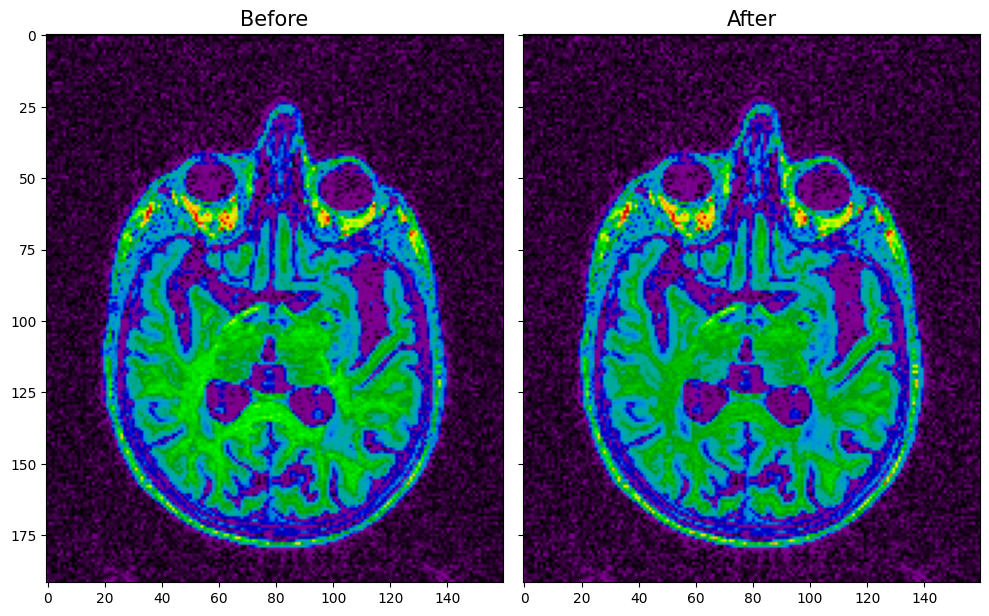

In [7]:
log_bias_field = bias_corrector.GetLogBiasFieldAsImage(raw_img_sitk)
corrected_image_full_resolution = raw_img_sitk / sitk.Exp( log_bias_field )

explore_3D_array_comparison(
    sitk.GetArrayFromImage(raw_img_sitk),
    sitk.GetArrayFromImage(corrected_image_full_resolution), 
    cmap='nipy_spectral')


#### Inspect the bias field

interactive(children=(IntSlider(value=95, description='SLICE', max=191), Output()), _dom_classes=('widget-inte…

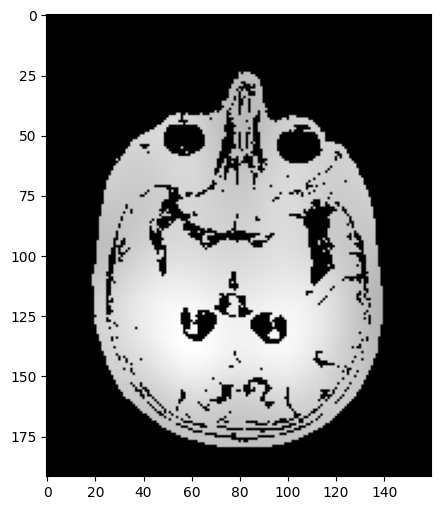

In [8]:
# bias field
temp = sitk.Exp(log_bias_field)
temp = sitk.Mask(temp, head_mask)
explore_3D_array(sitk.GetArrayFromImage(temp), cmap='gray')

#### Save the image

In [9]:
out_folder =  os.path.join(BASE_DIR, 'assets', 'preprocessed')
out_folder = os.path.join(out_folder, raw_example.split('.')[0]) # create folder with name of the raw file
os.makedirs(out_folder, exist_ok=True) # create folder if not exists

out_filename = add_suffix_to_filename(raw_example, suffix='biasFieldCorrected')
out_path = os.path.join(out_folder, out_filename)

print(raw_img_path[len(BASE_DIR):])
print(out_path[len(BASE_DIR):])

/assets/raw_examples/fsl-open-dev_sub-001_T1w.nii.gz
/assets/preprocessed/fsl-open-dev_sub-001_T1w/fsl-open-dev_sub-001_T1w_biasFieldCorrected.nii.gz


In [10]:
sitk.WriteImage(corrected_image_full_resolution, out_path)